## Machine learning with image descriptors

In [27]:
import pickle
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import cv2
import numpy as np
import gc

from sklearn.metrics import f1_score

We load the files.

In [30]:
sift = cv2.xfeatures2d.SIFT_create(32)
first = True

for i in range(0, 10):
    with open('images' + str(i), 'rb') as pickle_file:
        images = pickle.load(pickle_file)
    for image in images:
        kp2, des = sift.detectAndCompute(image, None)
        des = des.flatten()
        if des.size > 32*128 :
            des = des[:32*128]
        if des.size < 32*128 :
            des = np.concatenate((des, np.zeros(32*128 - des.size)))
        if first:
            X_raw = des
            first = False
        else:
            X_raw = np.concatenate([X_raw, des], axis = 0)
    pickle_file.close()
    gc.collect()


Here, we put X in it's right shape and then save it as a pickle archive.

In [39]:
rows = len(X)//(32*128)
X_raw = X_raw.reshape((rows, 32*128))

pickle_out = open("descriptor", "w+b")
pickle.dump(X, pickle_out)
pickle_out.close()

Next time, no need to process the datas : we can just import the descriptors by executing this cell.

In [2]:
# execute if the previous one hasn't been

with open('descriptor', 'rb') as pickle_file:
    X_raw = pickle.load(pickle_file)
    pickle_file.close()

Scale the datas.

In [3]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X_raw)

zip, shuffle and re-extract

In [4]:
with open('vehicletrgt', 'rb') as pickle_file:
    Y_unsh = pickle.load(pickle_file)
    pickle_file.close()

Y_unsh_reshaped = Y_unsh.reshape((Y_unsh.size,1))

XY_std = np.concatenate((X_std, Y_unsh_reshaped), axis = 1)
np.random.shuffle(XY_std)

X, Y = XY_std[:, :-1], XY_std[:, -1:].flatten().astype(int)

In [5]:
print(np.histogram(Y[:600]))

(array([246,   0,   0,   0,   0, 152,   0,   0,   0, 202], dtype=int64), array([2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]))


Reduce dimension with PCA

In [7]:
pca = PCA(n_components = 4*128)
X_redim = pca.fit_transform(X)

0.6131340331719394


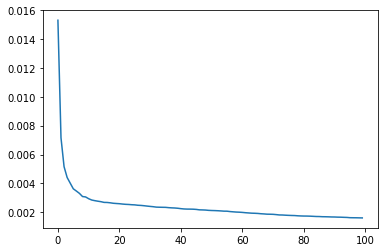

In [8]:
print(sum(pca.explained_variance_ratio_))
plt.plot(range(len(pca.explained_variance_ratio_[:100])), pca.explained_variance_ratio_[:100])

Split in train and test sets.

In [9]:
X_train, X_test = X_redim[:600], X_redim[600:]

Y_train, Y_test = Y[:600], Y[600:]

Try the knn and hope it's good

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn import neighbors, svm, model_selection

clf = neighbors.KNeighborsClassifier(n_neighbors=5, metric = "euclidean", weights = 'distance')
scores = cross_val_score(clf, X_train, Y_train, cv=5)

print("Moyenne obtenue pour la cross validation en 5-fold-cross : ", sum(scores)/len(scores), )

Moyenne obtenue pour la cross validation en 5-fold-cross :  0.41328427862135236


C:\Users\gadey\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\gadey\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
Meilleur estimateur trouvé:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')
Meilleurs paramètres:
{'metric': 'manhattan', 'n_neighbors': 12}


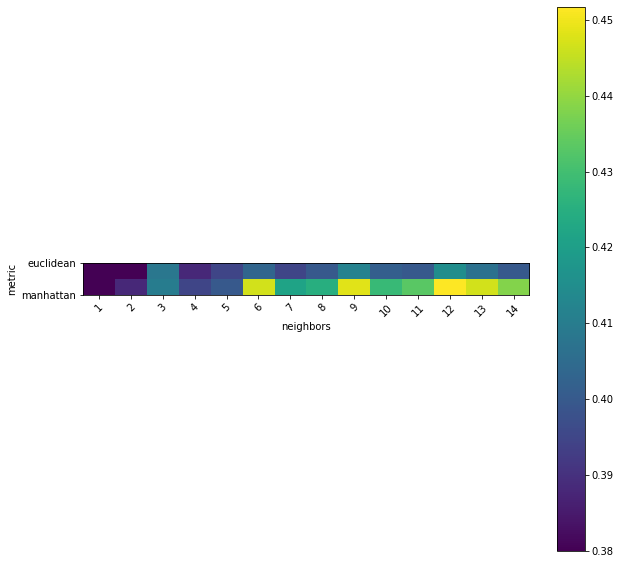

In [11]:
from sklearn.model_selection import GridSearchCV

neigbor_range = [i for i in range(1, 15)]
metrics = ["euclidean", "manhattan"]

parameters = { 'n_neighbors' :neigbor_range, 'metric':metrics }

clf = neighbors.KNeighborsClassifier(weights = 'uniform')
gridsearch=GridSearchCV(clf, parameters)
gridsearch.fit(X_train, Y_train)

print("Meilleur estimateur trouvé:")
print(gridsearch.best_estimator_)
print("Meilleurs paramètres:")
print(gridsearch.best_params_)

scores = gridsearch.cv_results_['mean_test_score'].reshape(len(metrics),len(neigbor_range))
plt.figure(figsize=[10,10])
plt.imshow(scores)
plt.xlabel('neighbors')
plt.ylabel('metric')
plt.xticks(np.arange(len(neigbor_range)), neigbor_range, rotation=45)
plt.yticks(np.arange(len(metrics)), metrics)
plt.colorbar()
plt.show()

In [31]:
clf = neighbors.KNeighborsClassifier(n_neighbors=12, metric = "manhattan", weights = 'distance').fit(X_train, Y_train)

Y_predict = clf.predict(X_test)
print("The f1 score is : ", f1_score(Y_test, Y_predict, average = None))

The f1 score is :  [0.53610136 0.44784194 0.10996852]


Now SVM with gaussian kernel

In [12]:
clf = svm.SVC(kernel = 'rbf', gamma = 'scale', C = 1)
scores = cross_val_score(clf, X_train, Y_train, cv=5)

print("Moyenne obtenue pour la cross validation en 5-fold-cross : ", sum(scores)/len(scores), )

Moyenne obtenue pour la cross validation en 5-fold-cross :  0.5063354809475613


C:\Users\gadey\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
Meilleur estimateur trouvé:
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Meilleurs paramètres:
{'C': 10.0, 'gamma': 0.0001}


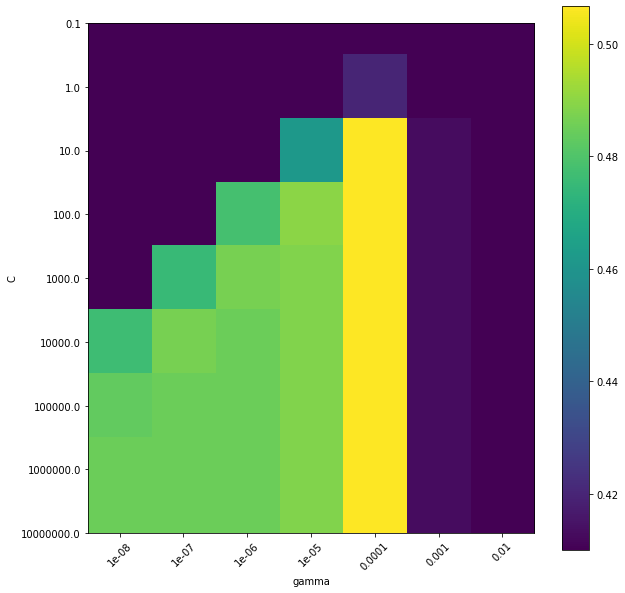

In [18]:
gamma_range=10**(np.arange(-8.,-1,1))
C_range=10**(np.arange(-1.,8,1)) 
parameters = { 'gamma': gamma_range, 'C':C_range }
SVM = svm.SVC(kernel='rbf')
gridsearch=model_selection.GridSearchCV(SVM, parameters)
gridsearch.fit(X_train,Y_train)
print("Meilleur estimateur trouvé:")
print(gridsearch.best_estimator_)
print("Meilleurs paramètres:")
print(gridsearch.best_params_)

scores = gridsearch.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
plt.figure(figsize=[10,10])
plt.imshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.colorbar()
plt.show()

In [25]:
clf = svm.SVC(kernel = 'rbf', gamma = 'scale', C = 10)
scores = cross_val_score(clf, X_train, Y_train, cv=5)

print("Moyenne obtenue pour la cross validation en 5-fold-cross : ", sum(scores)/len(scores), )

Moyenne obtenue pour la cross validation en 5-fold-cross :  0.5246297841721704


In [29]:
clf = svm.SVC(C=10, gamma = 'scale', kernel = 'rbf').fit(X_train, Y_train)

Y_predict = clf.predict(X_test)
print("The f1 score is : ", f1_score(Y_test, Y_predict, average = None))

The f1 score is :  [0.57601222 0.52399289 0.48334822]
